# Case X.
Lauri Marjanen, Team 10<br>
Neural Networks for Machine Learning Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

In [27]:
import copy
%pylab inline
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("tensorflow", tf.__version__)

Populating the interactive namespace from numpy and matplotlib
tensorflow 2.7.0


C:\ProgramData\Anaconda3\envs\Anaconda ML\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['copy', 'hist']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Background

The aim of this Notebook is ...

# Data

Different data processing methods attempted:
set image color = grayscale to change image dim from 128*128*3 to 128*128*1, did not help accuracy

In [28]:
batch_size = 128
img_height = 128
img_width = 128

curDir = os.getcwd()
train_dir = curDir + '/input/train'
test_dir = curDir + '/input/test'
val_dir = curDir + '/input/val'

# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)


# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size = (img_height, img_width),
  batch_size = batch_size)


Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [29]:
datagen = ImageDataGenerator( # Usaly xray machines force you to stand still in a specific position,
                              # so it does not make sense for the data to be augmented too much
  width_shift_range=0.01,
  height_shift_range=0.01,
  shear_range=0.01,
  zoom_range=0.01,
  fill_mode='nearest',
)
train_gen_ds = datagen.flow_from_directory(train_dir, target_size=(img_width,img_height), batch_size=batch_size,
                                           class_mode='binary')
val_gen_ds = datagen.flow_from_directory(val_dir, target_size=(img_width,img_height),
                                         batch_size=batch_size,class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model and training

The following model was used ...

In [31]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16,3, padding='same', activation= 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32,3, padding='same', activation= 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64,3, padding='same', activation= 'relu'),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate= 1e-4),
              metrics= ['accuracy'])

gen_model = keras.models.clone_model(model)
gen_model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate= 1e-4),
              metrics= ['accuracy'])

model.summary()
gen_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 64)       

# Results and Discussion

The following results were achieved ...

In [32]:
import time
EPOCHS = 3
VERBOSE = 1

t0 = time.time()

hist = model.fit(
  train_ds,
  validation_data= val_ds,
  verbose = VERBOSE,
  epochs = EPOCHS,
)

print("First model:",time.time() - t0)

Epoch 1/3
33/33 [==============================] - 34s 768ms/step - loss: 0.5439 - accuracy: 0.7757 - val_loss: 0.3528 - val_accuracy: 0.8332
Epoch 2/3
33/33 [==============================] - 23s 690ms/step - loss: 0.3681 - accuracy: 0.8543 - val_loss: 0.2343 - val_accuracy: 0.9243
Epoch 3/3
33/33 [==============================] - 24s 742ms/step - loss: 0.2782 - accuracy: 0.8881 - val_loss: 0.1765 - val_accuracy: 0.9406
First model: 81.6883192062378


In [33]:
t0 = time.time()

#gen_hist = gen_model.fit( # first model fit with unaltered data
#  train_ds,
#  validation_data= val_ds,
#  verbose = VERBOSE,
#  epochs = round(EPOCHS/2),
#)

gen_hist = gen_model.fit(
  train_gen_ds,
  validation_data= val_gen_ds,
  verbose = VERBOSE,
  epochs = round(EPOCHS),
)
print("Second model:",time.time() - t0)

Epoch 1/3
41/41 [==============================] - 131s 3s/step - loss: 0.4792 - accuracy: 0.7715 - val_loss: 0.7439 - val_accuracy: 0.6250
Epoch 2/3
41/41 [==============================] - 128s 3s/step - loss: 0.2828 - accuracy: 0.8946 - val_loss: 1.2160 - val_accuracy: 0.6250
Epoch 3/3
41/41 [==============================] - 125s 3s/step - loss: 0.1973 - accuracy: 0.9287 - val_loss: 0.4513 - val_accuracy: 0.7500
Second model: 386.9350838661194


# Conclusions

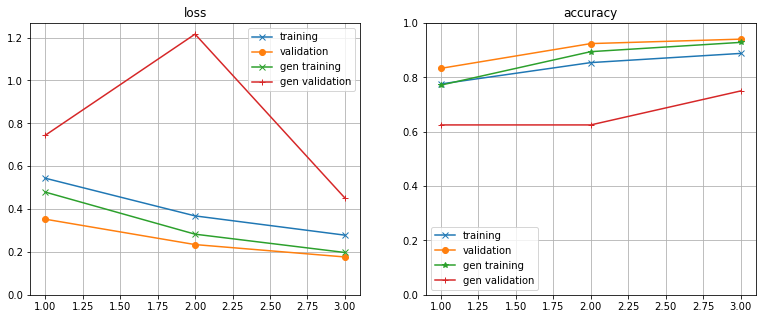

In [34]:
from IPython.core.pylabtools import figsize
from matplotlib.pyplot import figure, subplot, plot, title, ylim, legend, grid

x_axis = np.arange(len(hist.history['loss'])) + 1


figure(figsize(13,5))
subplot(1,2,1)
plot(x_axis, hist.history['loss'], 'x-', label = 'training')
plot(x_axis, hist.history['val_loss'], 'o-', label = 'validation')
plot(x_axis, gen_hist.history['loss'], 'x-', label = 'gen training')
plot(x_axis, gen_hist.history['val_loss'], '+-', label = 'gen validation')
title('loss')
ylim(0,)
legend()
grid()


subplot(1,2,2)
plot(x_axis, hist.history['accuracy'], 'x-', label = 'training')
plot(x_axis, hist.history['val_accuracy'], 'o-', label = 'validation')
plot(x_axis, gen_hist.history['accuracy'], '*-', label = 'gen training')
plot(x_axis, gen_hist.history['val_accuracy'], '+-', label = 'gen validation')
title('accuracy')
ylim(0,1.0)
legend()
grid()

In [35]:
print("Train Loss = ", 100 * (hist.history['val_loss'][EPOCHS - 1]), "%")
print("Train Accuracy = ", 100 * (hist.history['val_accuracy'][EPOCHS -1]),"%")

print("Generated data Train Loss = ", 100 * (gen_hist.history['val_loss'][EPOCHS -1]), "%")
print("Generated data Train Accuracy = ", 100 * (gen_hist.history['val_accuracy'][EPOCHS -1]),"%")

Train Loss =  17.646026611328125 %
Train Accuracy =  94.05561089515686 %
Generated data Train Loss =  45.13159692287445 %
Generated data Train Accuracy =  75.0 %


In [36]:
results = model.evaluate(test_ds,verbose=VERBOSE)
print("Model 1 test acc:", 100 * results[1])

results = gen_model.evaluate(test_ds,verbose=VERBOSE)
print("Model 2 test acc:", 100 * results[1])

5/5 [==============================] - 2s 152ms/step - loss: 0.4416 - accuracy: 0.7676
Model 1 test acc: 76.76281929016113
5/5 [==============================] - 2s 149ms/step - loss: 0.3783 - accuracy: 0.8349
Model 2 test acc: 83.49359035491943
